In [1]:
import sys
sys.path.append('..\\..')
import gdspy
import numpy as np
from importlib import reload
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator
from QCreator import meshing
reload(gdspy)


<module 'gdspy' from 'C:\\ProgramData\\Anaconda3\\envs\\py38\\lib\\site-packages\\gdspy\\__init__.py'>

In [2]:
jc = 0.5e-6  # 1e-6 # uA/um^2
layers_configuration = {
    'total': 0,
    'restricted area': 10,
    'for removing': 100,
    'JJs': 1,
    'air bridges': 2,
    'air bridge pads': 3,
    'air bridge sm pads': 4,
    'vertical gridlines': 0,
    'horizontal gridlines': 0,
    'inverted': 101,
    'bandages': 20
}

sample = creator.Sample('simple_fluxonium', layers_configuration)

# specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size = 4.7e3
sample.chip_geometry.sample_horizontal_size = 4.7e3
chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads, 350)
sample.add(chip_edge_ground)

In [3]:
# qubit params
flux_w = 10
flux_s = 6
flux_g = 20

In [4]:
fluxonium_squid =  {'jjs_height': 0.1,
                             'jjs_width': 0.115,
                             'jj_lead_width':0.5,
                             'chain_width':1.0,
                             'ics': 0.1*0.115*jc,
                             'icb': 0.5*1.0*jc,
                             'chain_junctions': 45,
                             'lm': 3.3e-12,
                             'squid_orientation': 'horizontal',
                             'jjs_distance': 0.16,
                             'chain_jj_distance': 0.1,
                             'chain_top_offset': 1.0,
                             'flux_line_outer_extension': 11}

In [5]:
from QCreator.elements.gflux_squid import GFluxControllableSquid

sl_position = (2350, 2350)

fluxonium_w = 20
fluxonium_s = 15
fluxonium_g = 30

squid = GFluxControllableSquid(name='fluxonium-squid', 
                               position=sl_position, 
                               w=fluxonium_w, s=fluxonium_s, g=fluxonium_g,
                               layer_configuration=sample.layer_configuration, 
                               squid_params=fluxonium_squid,
                               flux_w=flux_w, flux_s=flux_s, flux_g=flux_g)

sample.add(squid)

{'jjs_height': 0.1, 'jjs_width': 0.115, 'jj_lead_width': 0.5, 'chain_width': 1.0, 'ics': 5.75e-09, 'icb': 2.5e-07, 'chain_junctions': 45, 'lm': 3.3e-12, 'squid_orientation': 'horizontal', 'jjs_distance': 0.16, 'chain_jj_distance': 0.1, 'chain_top_offset': 1.0, 'flux_line_outer_extension': 11}


In [6]:
fluxonium_cap_length = 400
open_ends = []
capacitors = []
for open_end_id, port_name in enumerate(['port1', 'port2']):
    position = -np.exp(1j*squid.get_terminals()[port_name].orientation)*fluxonium_cap_length
    position = np.asarray([np.real(position), np.imag(position)])
    position += squid.get_terminals()[port_name].position
    
    open_end = elements.OpenEnd(name='fluxonium-open-end'+str(open_end_id),
                                position=position,
                                 w=[squid.get_terminals()[port_name].w],
                                 s=[squid.get_terminals()[port_name].s, squid.get_terminals()[port_name].s],
                                 g=squid.get_terminals()[port_name].g,
                                 orientation=squid.get_terminals()[port_name].orientation+np.pi,
                                 layer_configuration=sample.layer_configuration,
                                 h1=20,
                                 h2=10)
    open_ends.append(open_end)
    sample.add(open_end)
    capacitor = sample.connect_cpw(open_end, squid, 'wide', port_name, points=[], 
                                   name='fluxonium-cap'+str(open_end_id))

# Add DC line

In [7]:
pad_geometry = {'pad_w': 250, 'pad_s': 146, 'pad_g': 8, 'pad_length': 250, 'narrowing_length': 100, 'stub_length': 100,
                'z0': 50}
pad = elements.Pad('pad',
                   (2350, 600),
                   -np.pi/2,
                   flux_w,
                   flux_s, flux_g,
                   layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry,
                   **pad_geometry)
sample.add(pad)
sample.connect_cpw(pad, squid, 'port', 'flux', name='flux-line', points=[])

[CPW "flux-line", l=1695.000]

In [8]:
sample.draw_design()
sample.watch()

# TLS simulation

In [14]:
tls, connections_flat, element_assignments = sample.get_tls()
omegas, gammas, modes = tls.get_modes()
omegas/(2*np.pi)

array([2.63968085e+09, 4.62027710e+09, 3.52904445e+10, 6.95610536e+10,
       8.85696048e+10, 8.90747435e+10, 9.75815628e+10, 1.01024231e+11,
       1.16399483e+11, 1.17534290e+11, 1.50245721e+11, 1.50341745e+11,
       3.01095656e+11, 3.01143596e+11, 4.05504263e+11, 4.05517367e+11,
       4.68027634e+11, 4.68027634e+11, 4.68028275e+11, 4.68028275e+11,
       4.74583096e+11, 4.74613537e+11, 5.11696558e+11, 5.11696558e+11,
       5.11717516e+11, 5.11717516e+11])

In [10]:
kerr_matrix = tls.get_perturbation([0, 1])
kerr_matrix

array([[-3.49989879e+06, -3.98236900e+06],
       [-3.98236900e+06, -4.23274961e+08]])

## Zero flux 

In [11]:
modes_subsystems = tls.define_modes_parameters(
            omegas[:2]/(2 * np.pi), modes[:2], kerr_matrix,
            tls.get_phi_dc(modes[:2], tls.i_dc()), epsilon_cross=0.005)

modes_subsystems

{'0': {'subsystem_id': [0],
  'Ec': array([[6.2795444e-25]]),
  'El': array([[6.36007375e-28]]),
  'Ej': [1.8923593762338568e-24, 3.70244225784885e-21, 3.70244225784885e-21],
  'alpha': array([[1.09759904e-05],
         [9.06397276e-03],
         [9.06371177e-03]]),
  'dc_phase': array([[0.],
         [0.],
         [0.]])},
 '1': {'subsystem_id': [1],
  'Ec': array([[6.27634928e-25]]),
  'El': array([[5.83502789e-27]]),
  'Ej': [1.8923593762338568e-24, 3.70244225784885e-21, 3.70244225784885e-21],
  'alpha': array([[ 0.81426122],
         [-0.00904747],
         [ 0.00904672]]),
  'dc_phase': array([[0.],
         [0.],
         [0.]])}}

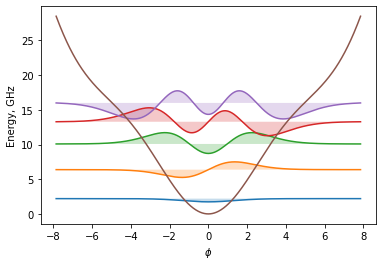

array([4.18016207e+09, 3.70472325e+09, 3.20065371e+09, 2.71640611e+09])

In [12]:
subsystem = modes_subsystems['1']
phi_grid = np.linspace(-np.pi*2.5, np.pi*2.5, 601)
dc_phase = modes_subsystems['1']['dc_phase']
tls.plot_wavefunctions_1d(subsystem, phi_grid, dc_phase, cutoff=5)
energies, wavefunctions = tls.solve_hamiltonian_eig_1d(subsystem, phi_grid, dc_phase, cutoff=5)
(energies[1:] - energies[:-1]) / (2 * np.pi * 1.054e-34)

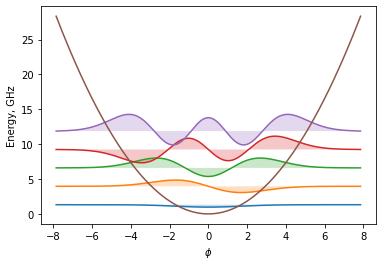

array([2.64072018e+09, 2.64033073e+09, 2.63997835e+09, 2.63991098e+09])

In [13]:
subsystem = modes_subsystems['0']
phi_grid = np.linspace(-np.pi*2.5, np.pi*2.5, 301)
dc_phase = modes_subsystems['0']['dc_phase']
tls.plot_wavefunctions_1d(subsystem, phi_grid, dc_phase, cutoff=5)
energies, wavefunctions = tls.solve_hamiltonian_eig_1d(subsystem, phi_grid, dc_phase, cutoff=5)
(energies[1:] - energies[:-1]) / (2 * np.pi * 1.054e-34)

## Half flux quantum

In [27]:
currents = np.linspace(-1e-4, 1e-4)
# tls.dc_energy_spectrum_1d('1', pad, phi_grid, currents, omegas[:2], modes[:2], kerr_matrix,
#                               cutoff=4)
cutoff = 5
energies = np.zeros((len(currents), cutoff))
for current_id, current in enumerate(currents):
    pad.idc = current
    psi_dc = tls.get_psi_dc(modes[:2], tls.i_dc())
    dc_phase = tls.get_phi_dc(modes[:2], tls.i_dc())
    print(dc_phase)
    modes_subsystems = tls.define_modes_parameters(omegas[:2], modes[:2], kerr_matrix, dc_phase, epsilon_cross=0.005)
    E, wavefunctions = tls.solve_hamiltonian_eig_1d(modes_subsystems['1'], phi_grid, dc_phase, cutoff=cutoff)
    energies[current_id, :] = np.asarray(E)

plt.plot(currents, energies)

[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

In [25]:
%debug

> d:\documents-cloud\qubits\simulation\qcreator\qcreator\transmission_line_simulator.py(2333)potential_1d()
   2331     for jj_id, e_j in enumerate(e_j):
   2332         phi_dc_jj = phi_dc[jj_id][0]
-> 2333         potential += e_j * (1 - np.cos(alpha[jj_id][0] * phi + phi_dc_jj))
   2334     return potential
   2335 

ipdb> phi
array([-7.85398163, -7.80162176, -7.74926188, -7.696902  , -7.64454212,
       -7.59218225, -7.53982237, -7.48746249, -7.43510261, -7.38274274,
       -7.33038286, -7.27802298, -7.2256631 , -7.17330323, -7.12094335,
       -7.06858347, -7.01622359, -6.96386372, -6.91150384, -6.85914396,
       -6.80678408, -6.75442421, -6.70206433, -6.64970445, -6.59734457,
       -6.54498469, -6.49262482, -6.44026494, -6.38790506, -6.33554518,
       -6.28318531, -6.23082543, -6.17846555, -6.12610567, -6.0737458 ,
       -6.02138592, -5.96902604, -5.91666616, -5.86430629, -5.81194641,
       -5.75958653, -5.70722665, -5.65486678, -5.6025069 , -5.55014702,
       -5.49778714, -